In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 100)

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import re
import string
import nltk
import xgboost

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

import sys
if not 'Notebooks/Individual/Jake' in sys.path:
    sys.path.append('Notebooks/Individual/jake')
from functions import ScoreModel, CleanText

import IPython
sound_file = '../../../data/sounds/puzzle_solved_jingle.wav'

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix

from textblob import TextBlob, Word
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ultim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ultim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_data = pd.read_csv("../../../data/NLP/train.csv")
val_data = pd.read_csv("../../../data/NLP/validate.csv")
train_data.head()

,review,voted_up
0,A+++++++,True
1,Wide spread crashes on Nvidia grpahics cards and amateur hour with relying on too many external ...,False
2,Can confirm the roads in New Vegas look exactly like the roads here in Vegas in 2020,True
3,we need chinese pls!!!!!,True
4,:),True


In [3]:
train_data["voted_up"] = train_data["voted_up"].astype(int)

train_data.head()

,review,voted_up
0,A+++++++,1
1,Wide spread crashes on Nvidia grpahics cards and amateur hour with relying on too many external ...,0
2,Can confirm the roads in New Vegas look exactly like the roads here in Vegas in 2020,1
3,we need chinese pls!!!!!,1
4,:),1


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9017 entries, 0 to 9016
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    9017 non-null   object
 1   voted_up  9017 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 105.8+ KB


In [5]:
train_data["voted_up"].value_counts(normalize=True)

1    0.869025
0    0.130975
Name: voted_up, dtype: float64

In [6]:
val_data["voted_up"].value_counts(normalize=True)

True     0.866711
False    0.133289
Name: voted_up, dtype: float64

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
punct = string.punctuation

lemma = nltk.WordNetLemmatizer()

In [8]:
train_data['clean_review'] = train_data['review'].apply(lambda x: CleanText(x.lower()))

train_data.head(10)

,review,voted_up,clean_review
0,A+++++++,1,[]
1,Wide spread crashes on Nvidia grpahics cards and amateur hour with relying on too many external ...,0,"[wide, spread, crash, nvidia, grpahics, card, amateur, hour, relying, many, external, resource, ..."
2,Can confirm the roads in New Vegas look exactly like the roads here in Vegas in 2020,1,"[confirm, road, new, vega, look, exactly, like, road, vega, 2020]"
3,we need chinese pls!!!!!,1,"[need, chinese, pls]"
4,:),1,[]
5,"Fantastic setup, needs work (I'm forgiving, its only alpha). Great game and better played with f...",1,"[fantastic, setup, need, work, im, forgiving, alpha, great, game, better, played, friend, try, a..."
6,Nostalgia,1,[nostalgia]
7,oh my god yes,1,"[oh, god, yes]"
8,"While this game is an older release it plays well. With a new DLC just released, it is even bett...",1,"[game, older, release, play, well, new, dlc, released, even, better, also, replay, value, game, ..."
9,I've been playing this game for ~10 years on and off.\r\n\r\nIf you enjoy roguelikes - this is w...,1,"[ive, playing, game, 10, year, enjoy, roguelikes, well, worth, time, pick]"


In [9]:
df_down = train_data.loc[train_data['voted_up'] == 0]
df_up = train_data.loc[train_data['voted_up'] == 1]

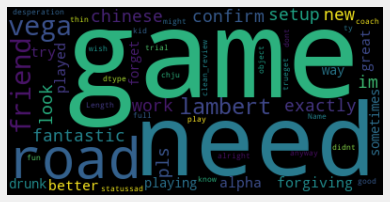

<Figure size 1440x720 with 0 Axes>

In [10]:
wordcloud = WordCloud(max_words=100, width=400, height=200).generate(str(df_up["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

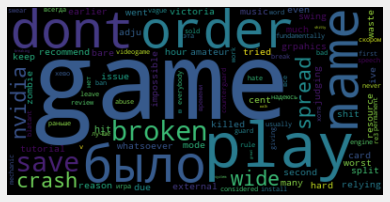

<Figure size 1440x720 with 0 Axes>

In [11]:
wordcloud = WordCloud(max_words=100, width=400, height=200).generate(str(df_down["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

In [20]:
vector = TfidfVectorizer(analyzer=CleanText, ngram_range=(2, 2))
X = vector.fit_transform(train_data["review"])

X_df = pd.DataFrame(X.toarray())
X_df.columns = vector.get_feature_names()
X_df.head(3)

,,0,00,000,001,00s,01,010,015,01510,...,큰,플레이,플레이못하고,하기엔,하는데,하면,할만함,ﾉ,ﾌﾌ,ﾚ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#X = X_df.drop("user_suggestion", axis = 1, inplace=True)
y = train_data["voted_up"]

X_train, X_test, y_train, y_test = train_test_split(X_df, y, random_state=57)

baseline = RandomForestClassifier(n_estimators=100)
baseline.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
ScoreModel(baseline, X_train, y_train)

Accuracy:   0.9982253771073647
F1 Score:   0.9989811512990322
Recall:     0.999320536775947
Precision:  0.9986419962654898
ROC_AUC:    0.995088839816545


In [16]:
ScoreModel(baseline, X_test, y_test)

Accuracy:   0.8682926829268293
F1 Score:   0.9291676603863581
Recall:     0.9994869163673679
Precision:  0.8680926916221033
ROC_AUC:    0.5160833274647297


In [24]:
IPython.display.Audio(sound_file, autoplay=True, rate=1000)